In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import bioframe
import cooler

import cooltools
from cooltools.lib.numutils import adaptive_coarsegrain
from cooltools.lib.plotting import *

import multiprocess as mp
num_cores = mp.cpu_count()


import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1
import logging, matplotlib
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

## parameters for nice plots
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.cmap'] = 'fall'
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 10

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_co

In [2]:
from akita_utils.tsv_gen_utils import (
    filter_by_chrmlen,
    filter_by_overlap_num,
    filter_by_chromID,
)

In [3]:
# dot data
dots_file = "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features/mustache_HiC_ES.mm10.mapq_30.10000.tsv"

In [4]:
dots = pd.read_csv(dots_file, sep="\t")

In [5]:
chromID_to_drop = ["chrX", "chrY", "chrM"]

In [6]:
chrom_sizes_file = "/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced"
seq_length = 1310720

In [7]:
dots = filter_by_chromID(dots, chrom_column='BIN1_CHR', chrID_to_drop=chromID_to_drop)

In [8]:
dots = filter_by_chromID(dots, chrom_column='BIN2_CHROMOSOME', chrID_to_drop=chromID_to_drop)

In [9]:
dots = dots.rename(columns={"BIN1_CHR": "chrom", "BIN1_START": "start", "BIN1_END": "end"})

In [10]:
dots = filter_by_chrmlen(
        dots,
        chrom_sizes_file,
        seq_length,
    )

In [11]:
dots = dots.rename(columns={"chrom": "chrom1", "start": "start1", "end": "end1"})

In [13]:
dots = dots.rename(columns={"BIN2_CHROMOSOME": "chrom", "BIN2_START": "start", "BIN2_END": "end"})

In [14]:
dots = filter_by_chrmlen(
        dots,
        chrom_sizes_file,
        seq_length,
    )

In [16]:
dots = dots.rename(columns={"chrom": "chrom2", "start": "start2", "end": "end2"})

In [26]:
# boundary data
boundaries_file = "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation"

In [27]:
boundaries = pd.read_csv(boundaries_file, sep="\t")

In [28]:
# filtering strong boundaries

window_size = boundaries_file.split("window_")[1].split(".")[0]
boundary_key, insulation_key = (
    f"boundary_strength_{window_size}",
    f"log2_insulation_score_{window_size}",
)

boundary_strength_thresh = 0.25
boundary_insulation_thresh = 0

boundaries = boundaries.iloc[
    (boundaries[boundary_key].values > boundary_strength_thresh)
    * (
        boundaries[insulation_key].values
        < boundary_insulation_thresh
    )
]

In [56]:
# let's select 4 random dots
df_of_interest = dots.sample(n=16)

In [57]:
# analysis parameters

res = 10_000 ## common resolution for analyzing TADs/dots

genome_folder = '/project/fudenber_735/genomes/mm10/'
genome_fasta = genome_folder+'mm10.fa'
genome_chromsizes = genome_folder+'mm10.chrom.sizes.reduced'
                         
# high-resolution reprocessed publically-available data from Bonev et al. 2017
bonev_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
bonev_cooler = cooler.Cooler(bonev_file+'::resolutions/'+str(res))

# view for analyzing only autosomes, extracted from cooler chromsizes
# view_df = cooltools.lib.make_cooler_view(bonev_cooler)[:19]

In [58]:
df_of_interest

,chrom1,start1,end1,chrom2,start2,end2,FDR,DETECTION_SCALE
2221,chr4,22130000,22140000,chr4,22360000,22370000,0.039352,2.111213
2364,chr4,136900000,136910000,chr4,137060000,137070000,0.026209,2.111213
1280,chr2,69950000,69960000,chr2,71060000,71070000,0.039211,2.111213
4929,chr9,64350000,64360000,chr9,64670000,64680000,0.005652,6.400000
5628,chr10,85450000,85460000,chr10,85620000,85630000,0.041232,2.599208
161,chr1,111660000,111670000,chr1,112450000,112460000,0.018064,2.599208
6230,chr11,119040000,119050000,chr11,119540000,119550000,0.038095,2.111213
3328,chr6,145400000,145410000,chr6,145790000,145800000,0.039974,4.222425
4084,chr7,110050000,110060000,chr7,111060000,111070000,0.003593,3.200000
2697,chr5,99220000,99230000,chr5,99590000,99600000,0.001574,3.675835


/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur
/tmp/SLURM_21382829/ipykernel_26022/3203012906.py:29: RuntimeWarning: divide by zero encountered in log10
  np.log10(mat),
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numu

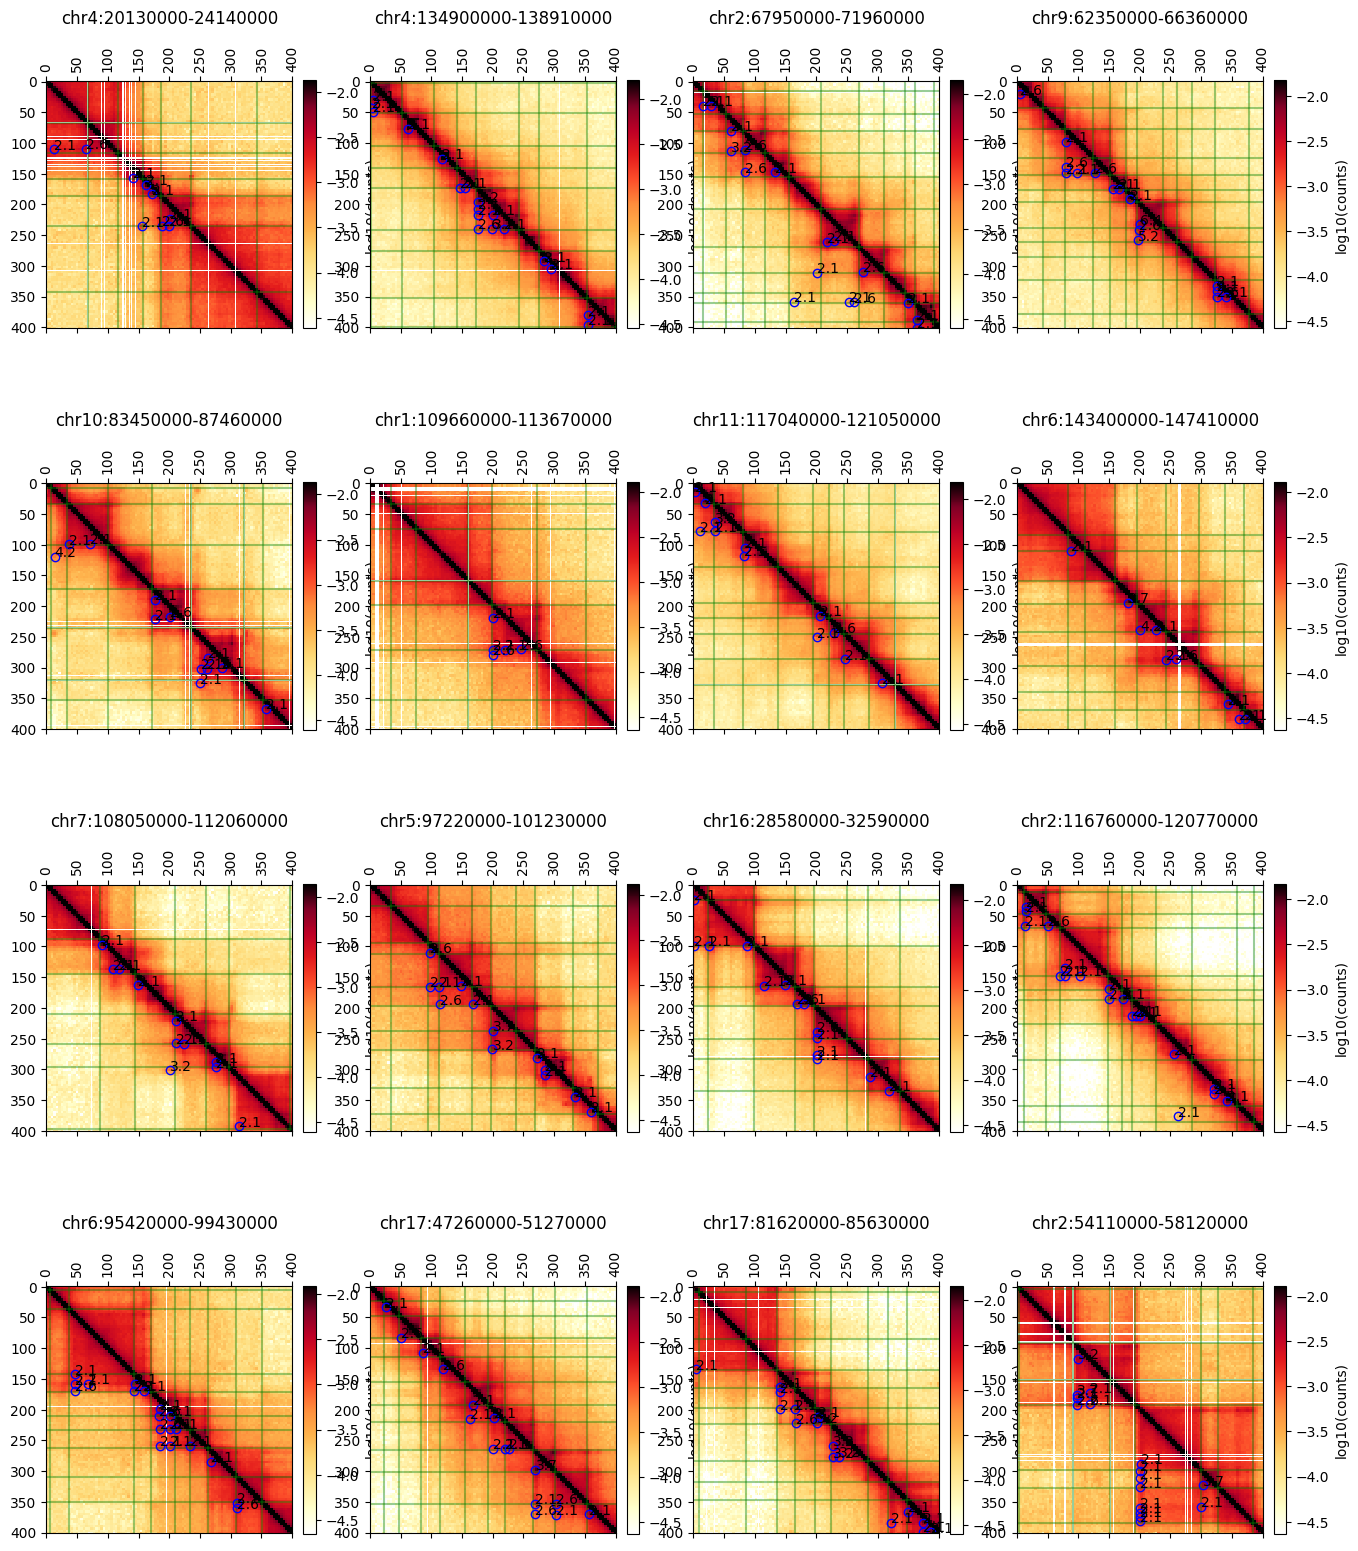

In [59]:
plt_width = 4
num_plots = 4
c=0
fig = plt.figure(figsize=(num_plots*plt_width, num_plots*(plt_width+1)))

padding = 2000000
smoothed = '_smoothed'
fetch_region = True

for s in df_of_interest.itertuples():
    chrom = s.chrom1
    start = s.start1 
    end = s.end1
    mseq_str = '%s:%d-%d' % (chrom, start-padding, end+padding)
    region_start = start-padding
    region_boundaries = bioframe.select(boundaries, mseq_str, cols=['chrom','start','end'])
    
    if fetch_region:
        mat = bonev_cooler.matrix(balance=True).fetch(mseq_str)
    
    if smoothed == '_smoothed': 
        mat = adaptive_coarsegrain(mat,  mat,  cutoff=2, max_levels=2)

    c+=1
    plt.subplot(num_plots,num_plots,c)
    vm = np.log10(np.nanmedian(np.diag(mat,3))*.5)

    im = plt.matshow(
        np.log10(mat),
        vmin=vm-2.5, vmax=vm+.25, fignum=False) 
    
    for boundary_index in range(len(region_boundaries)):
        boundary_start_bin, boundary_end_bin = ((region_boundaries[['start','end']].iloc[boundary_index].values.astype(int) - (start-padding)) //res )
        for boundary_bin in range(boundary_start_bin, boundary_end_bin):
            plt.axvline(x=boundary_bin, color='green', alpha=0.4)
            plt.axhline(y=boundary_bin, color='green', alpha=0.4)

    region_dots = bioframe.select(dots, mseq_str, cols=['chrom1','start1','end1'])
    for i in range(len(region_dots)):
        s1,s2,e1,e2 =( ( region_dots[['start1','end1','start2','end2']].iloc[i].values.astype(int)
                        -region_start) //res ) 
        s,e = .5*(s1+s2), .5*(e1+e2)
        if s < 0 or e > len(mat): continue
        plt.plot(  s,e,'o',lw=3.25,color="blue",mfc='none')
        plt.text(  s,e, np.round(float(region_dots.iloc[i].DETECTION_SCALE),1))
    
    plt.colorbar(im ,fraction=0.046, pad=0.04, label='log10(counts)')
    plt.title(mseq_str , y=1.2)
    plt.grid(False)
    plt.xticks(rotation=90)